# Learning form-meaning systematicity 

## Sean Trott

Is there learnable form-meaning systematicity at the sub-morphemic level, beyond what we'd expect by chance? And does it occur more in particular syllable components than others (e.g. *onsets* vs. *codas* vs. *nuclei*)?

In this analysis, we ask whether a Linear SVM classifier can learn to predict a target label (e.g. a particular *onset*, such as **l**) from the word embedding of the word associated with that label. 


In [1]:
import os 
import gensim
import numpy as np
import pandas as pd
import re

# Variables
MODEL_PATH = os.environ['WORD2VEC_PATH']
ROOT_PATH = 'data/raw/roots_celex_monosyllabic.txt'

LOAD_NEW_MODEL = False

## Loading the data

First we load our data. We used only monosyllabic, monomorphemic words from the CELEX database. We also require that these words contain no capital letters, and are at least three characters.

In [2]:
MIN_LENGTH = 3

In [3]:
def construct_syllable_structure(syllable, nuclei='[5@694{8312i7u$#eqFEIQVU$]|ju'):
    """Return dict of possible onset, nucleus, and coda, using phonetic transcription."""
    nucleus = re.findall(nuclei, syllable)
    if len(nucleus) < 1:
        return None
    onset, coda = syllable.split(nucleus[0])
    return {'nucleus': nucleus[0],
            'onset': onset,
            'coda': coda}

In [4]:
entries = open(ROOT_PATH, "r").read().split("\n")
entries[0]

'a\\1\\1\\1'

In [5]:
words = [(entry.split("\\")[0], entry.split("\\")[-1]) for entry in entries if entry != "" and entry.islower()]
words[0]

('a', '1')

In [6]:
words = [(w[0], construct_syllable_structure(w[1])) for w in words if len(w[0]) >= MIN_LENGTH]
words[0]

('ace', {'nucleus': '1', 'onset': '', 'coda': 's'})

In [7]:
roots_to_syllables = dict(words)
roots_to_syllables['ace']

{'nucleus': '1', 'onset': '', 'coda': 's'}

In [8]:
N = len(roots_to_syllables)
print("This resulted in an initial set of {num_tokens} tokens.".format(num_tokens=N))

This resulted in an initial set of 2069 tokens.


## Loading the word2vec model and creating our dataset

In [9]:
if LOAD_NEW_MODEL:
    model = gensim.models.KeyedVectors.load_word2vec_format(MODEL_PATH, binary=True)

In [10]:
def create_dataset(roots_to_syllables, model, syllable_component='nucleus'):
    """Return mappings from vectors to specified syllable component (e.g. 'nucleus')."""
    X, y, words = [], [], []
    for root, syllable in roots_to_syllables.items():
        if root in model:
            syl = syllable[syllable_component]
            if syl != '':
                X.append(model[root])
                y.append(syl)
                words.append(root)
    return np.array(X), np.array(y), words

### Saving data so we don't have to load word2vec each time

In [18]:
import json
if LOAD_NEW_MODEL is False:
    X_onset, y_onset, words_onset = create_dataset(roots_to_syllables, model, 'onset')
    X_coda, y_coda, words_coda = create_dataset(roots_to_syllables, model, 'coda')
    X_nucleus, y_nucleus, words_nucleus = create_dataset(roots_to_syllables, model, 'nucleus')
    data = {'onset': {'X': X_onset, 'y': y_onset, 'words': words_onset},
            'coda': {'X': X_coda, 'y': y_coda, 'words': words_coda},
            'nucleus': {'X': X_nucleus, 'y': y_nucleus, 'words': words_nucleus}}
    with open('data/processed/data.json', 'w') as outfile:
        json.dump(data, outfile)
    

TypeError: Object of type 'ndarray' is not JSON serializable

array([[-0.07910156,  0.00222778, -0.00188446, ..., -0.23144531,
        -0.04003906,  0.27148438],
       [ 0.15429688, -0.24316406, -0.0255127 , ..., -0.328125  ,
        -0.23144531,  0.05200195],
       [ 0.07470703,  0.01635742,  0.08789062, ..., -0.0456543 ,
         0.01385498, -0.08398438],
       ...,
       [-0.07421875, -0.10205078,  0.20117188, ..., -0.25390625,
         0.06054688, -0.21289062],
       [-0.04248047,  0.16015625, -0.2265625 , ...,  0.18945312,
        -0.00692749,  0.1328125 ],
       [ 0.18554688,  0.16894531,  0.00267029, ..., -0.33007812,
         0.05004883, -0.21191406]], dtype=float32)

## Training and testing our classifier

In [14]:
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.svm import LinearSVC

### Helper functions

In [15]:
NUM_PERMUTATIONS = 100

def get_model_metrics(y_true, y_pred):
    """Return a dictionary of relevant model metrics.

    Parameters
    ----------
    y_true: numpy.array
      array of actual y values
    y_pred: numpy.array
      array of predicted y values

    Returns
    -------
    dict
      dictionary including F1 score, precision, recall
    """
    return {'f1': metrics.f1_score(y_true=y_true, y_pred=y_pred, average='weighted'),
            'recall': metrics.recall_score(y_true=y_true, y_pred=y_pred, average='weighted'),
            'precision': metrics.precision_score(y_true=y_true, y_pred=y_pred, average='weighted'),
            'accuracy': metrics.accuracy_score(y_true=y_true, y_pred=y_pred)}

def evaluate_classifier_with_cv(X, y, n_folds, clf, shuffled=False):
    """Run cross-validation with parameters."""
    model_performance = []
    kfolds = KFold(n_splits=n_folds, shuffle=True)
    for fold, (train_index, validation_index) in enumerate(kfolds.split(X)):
        X_train, X_valid = X[train_index], X[validation_index]
        y_train, y_valid = y[train_index], y[validation_index]
        clf.fit(X=X_train, y=y_train)
        # Make model predictions
        y_pred_train = clf.predict(X=X_train)
        y_pred_valid = clf.predict(X=X_valid)
        # Evaluate model
        training_metrics = get_model_metrics(y_train, y_pred_train)
        validation_metrics = get_model_metrics(y_valid, y_pred_valid)
        model_performance.append({
            'recall_train': training_metrics['recall'],
            'recall_valid': validation_metrics['recall'],
            'precision_train': training_metrics['precision'],
            'precision_valid': validation_metrics['precision'],
            'f1_train': training_metrics['f1'],
            'f1_valid': validation_metrics['f1'],
            'accuracy_train': training_metrics['accuracy'],
            'accuracy_valid': validation_metrics['accuracy'],
            'fold': fold,
            'shuffled': shuffled
        })
    df_model_performance = pd.DataFrame.from_dict(model_performance)
    return df_model_performance

def permutation_test(X, y, clf, n=100):
    """Get estimate of model accuracy on randomly shuffled data."""
    performances = []
    for shuffle in range(n):
        if shuffle % 10 == 0:
            print("{pct}% done...".format(pct=round(shuffle/n, 2)*100))
        y_shuffle = np.random.permutation(y)
        df_performance = evaluate_classifier_with_cv(
            X, y_shuffle, n_folds=2, clf=clf, shuffled=True)
        performances.append(df_performance)
    shuffle_performance = pd.concat(performances)
    return shuffle_performance

### Training and evaluation for each syllable component

For each syllable component, we want to know whether a classifier can learn to predict **phonetic form** from **word embeddings**. We will evaluate our classifier using two-fold cross-validation, and extract the F1-scores on the validation sets. 

We will then compare these to the F1-scores on the validation sets for randomly shuffled labels, as an estimate of the *null distribution*.

To speed things up, we will reduce the dimensionality of the word vectors.

In [16]:
num_tokens = []
components = []
for syllable_component in ['onset', 'nucleus', 'coda']:
    print("Finding systematicity in {syl} component...".format(syl=syllable_component))
    X, y, words = create_dataset(roots_to_syllables, model, syllable_component)
    N = len(words)
    print("Using {num} words".format(num=N))
    num_tokens.append(N)
    pca = PCA(n_components=20)
    X_reduced = pca.fit_transform(X)
    clf = LinearSVC()
    df_performance = evaluate_classifier_with_cv(
        X_reduced, y, n_folds=2, clf=clf, shuffled=False)
    permuted = permutation_test(X_reduced, y, clf, NUM_PERMUTATIONS)
    df = pd.concat([df_performance, permuted])
    df['component'] = [syllable_component for _ in range(len(df))]
    components.append(df)

Finding systematicity in onset component...
Using 1933 words


/Users/strott/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/strott/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/strott/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/strott/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


0.0% done...
10.0% done...
20.0% done...
30.0% done...
40.0% done...
50.0% done...
60.0% done...
70.0% done...
80.0% done...
90.0% done...
Finding systematicity in nucleus component...
Using 2021 words
0.0% done...
10.0% done...
20.0% done...
30.0% done...
40.0% done...
50.0% done...
60.0% done...
70.0% done...
80.0% done...
90.0% done...
Finding systematicity in coda component...
Using 1790 words
0.0% done...
10.0% done...
20.0% done...
30.0% done...
40.0% done...
50.0% done...
60.0% done...
70.0% done...
80.0% done...
90.0% done...


In [17]:
df_all = pd.concat(components)

## Evaluation of systematicity for each syllable component

In [26]:
import matplotlib.pyplot as plt

### Onsets

In [19]:
df_onsets = df_all[df_all['component']=="onset"]

In [42]:
mean_f1_valid = df_onsets[df_onsets['shuffled']==False]['f1_valid'].mean()
print("The mean F1 score for the true distribution is {f1}.".format(f1=round(mean_f1_valid, 3)))

The mean F1 score for the true distribution is 0.047.


Below, we see that the mean F1 score for the true distribution (dotted line) is higher than the majority of the F1 scores for the randomly permuted distributions.

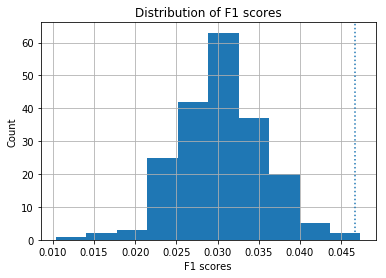

In [43]:
df_onsets[df_onsets['shuffled']==True].hist(column='f1_valid')
plt.axvline(x=mean_f1_valid, linestyle="dotted")
plt.title("Distribution of F1 scores")
plt.xlabel("F1 scores")
plt.ylabel("Count")
plt.show()

### Nuclei

In [45]:
df_nucleus = df_all[df_all['component']=="nucleus"]

In [46]:
mean_f1_valid = df_nucleus[df_nucleus['shuffled']==False]['f1_valid'].mean()
print("The mean F1 score for the true distribution is {f1}.".format(f1=round(mean_f1_valid, 3)))

The mean F1 score for the true distribution is 0.131.


Below, we see that the mean F1 score for the true distribution (dotted line) is higher than the majority of the F1 scores for the randomly permuted distributions.

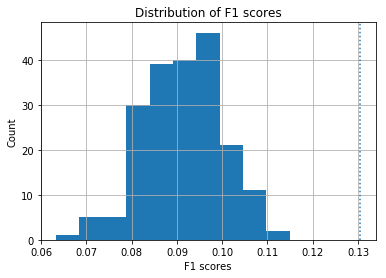

In [47]:
df_nucleus[df_nucleus['shuffled']==True].hist(column='f1_valid')
plt.axvline(x=mean_f1_valid, linestyle="dotted")
plt.title("Distribution of F1 scores")
plt.xlabel("F1 scores")
plt.ylabel("Count")
plt.show()

### Coda

In [48]:
df_coda = df_all[df_all['component']=="coda"]

In [49]:
mean_f1_valid = df_coda[df_coda['shuffled']==False]['f1_valid'].mean()
print("The mean F1 score for the true distribution is {f1}.".format(f1=round(mean_f1_valid, 3)))

The mean F1 score for the true distribution is 0.085.


Below, we see that the mean F1 score for the true distribution (dotted line) is higher than the majority of the F1 scores for the randomly permuted distributions.

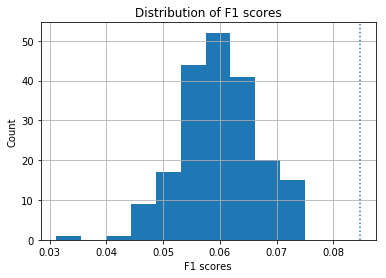

In [50]:
df_coda[df_coda['shuffled']==True].hist(column='f1_valid')
plt.axvline(x=mean_f1_valid, linestyle="dotted")
plt.title("Distribution of F1 scores")
plt.xlabel("F1 scores")
plt.ylabel("Count")
plt.show()